**操作光谱**
* @Data: 2024-01-09
* @Author: Rui Zhu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

---
# Smoothing
* https://specutils.readthedocs.io/en/stable/manipulation.html#smoothing

## 使用kernel进行smooth

方法1: smooth高级封装函数

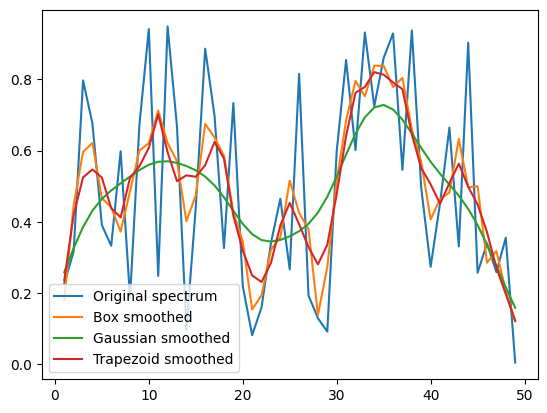

In [2]:
from specutils import Spectrum1D
from specutils.manipulation import box_smooth, gaussian_smooth, trapezoid_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49)*u.Jy)

spec1_bsmooth = box_smooth(spec1, width=3)
spec1_gsmooth = gaussian_smooth(spec1, stddev=3)
spec1_tsmooth = trapezoid_smooth(spec1, width=3)

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_bsmooth.spectral_axis, spec1_bsmooth.flux, label="Box smoothed")
ax.plot(spec1_gsmooth.spectral_axis, spec1_gsmooth.flux, label="Gaussian smoothed")
ax.plot(spec1_tsmooth.spectral_axis, spec1_tsmooth.flux, label="Trapezoid smoothed")
ax.legend()

方法2: 使用astropy创建kernel

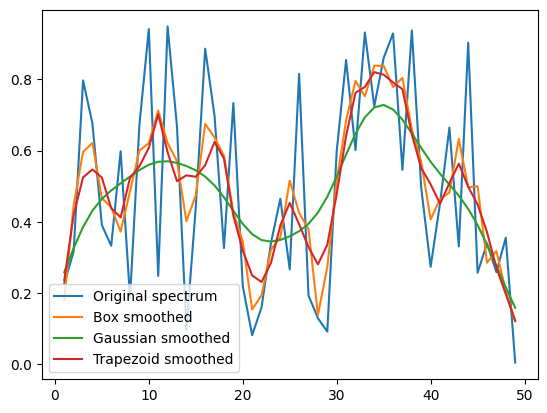

In [3]:
from astropy.convolution import Box1DKernel, Gaussian1DKernel, Trapezoid1DKernel
from specutils.manipulation import convolution_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49) * u.Jy)

box1d_kernel = Box1DKernel(width=3)
gaussian1d_kernel = Gaussian1DKernel(stddev=3)
trapezoid1d_kernel = Trapezoid1DKernel(width=3)

spec1_bsmooth = convolution_smooth(spec1, box1d_kernel)
spec1_gsmooth = convolution_smooth(spec1, gaussian1d_kernel)
spec1_tsmooth = convolution_smooth(spec1, trapezoid1d_kernel)

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_bsmooth.spectral_axis, spec1_bsmooth.flux, label="Box smoothed")
ax.plot(spec1_gsmooth.spectral_axis, spec1_gsmooth.flux, label="Gaussian smoothed")
ax.plot(spec1_tsmooth.spectral_axis, spec1_tsmooth.flux, label="Trapezoid smoothed")
ax.legend()

## 使用中值滤波器进行smooth
* 注意：这种方法的flux不恒定，并且误差不进行传递

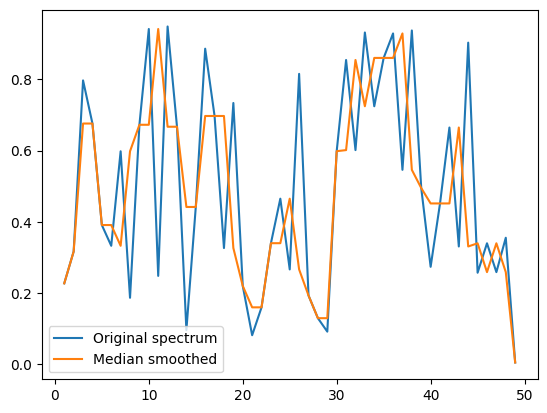

In [4]:
from specutils.manipulation import median_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49) * u.Jy)
spec1_msmooth = median_smooth(spec1, width=3) 

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_msmooth.spectral_axis, spec1_msmooth.flux, label="Median smoothed")
ax.legend()

---
# Resampling
* https://specutils.readthedocs.io/en/stable/manipulation.html#resampling
* 包含3种resampling的方法: FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
* 只有FluxConservingResampler可以同时处理误差，另外两种方法会自动忽略误差

In [5]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x17670e9f0>

4825.0302734375 Angstrom 5086.27587890625 Angstrom


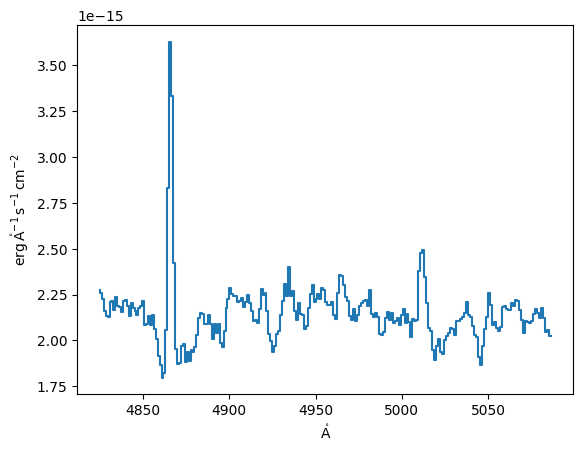

In [26]:
"""
加载试验光谱
"""
path = "/Users/rui/Code/1_Astronote/26_specutils/material/spec-1323-52797-0012.fits"

hdul = fits.open(path)
spec_data = hdul[1].data[1020: 1250]

lamb = 10**spec_data['loglam'] * u.AA 
flux = spec_data['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 

input_spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

f, ax = plt.subplots()  
ax.step(input_spec.spectral_axis, input_spec.flux) 
print(input_spec.spectral_axis.min(), input_spec.spectral_axis.max())

In [28]:
"""
定义新的波长网格
"""
new_disp_grid = np.arange(4800, 5200, 3) * u.AA
new_disp_grid

<Quantity [4800., 4803., 4806., 4809., 4812., 4815., 4818., 4821., 4824.,
           4827., 4830., 4833., 4836., 4839., 4842., 4845., 4848., 4851.,
           4854., 4857., 4860., 4863., 4866., 4869., 4872., 4875., 4878.,
           4881., 4884., 4887., 4890., 4893., 4896., 4899., 4902., 4905.,
           4908., 4911., 4914., 4917., 4920., 4923., 4926., 4929., 4932.,
           4935., 4938., 4941., 4944., 4947., 4950., 4953., 4956., 4959.,
           4962., 4965., 4968., 4971., 4974., 4977., 4980., 4983., 4986.,
           4989., 4992., 4995., 4998., 5001., 5004., 5007., 5010., 5013.,
           5016., 5019., 5022., 5025., 5028., 5031., 5034., 5037., 5040.,
           5043., 5046., 5049., 5052., 5055., 5058., 5061., 5064., 5067.,
           5070., 5073., 5076., 5079., 5082., 5085., 5088., 5091., 5094.,
           5097., 5100., 5103., 5106., 5109., 5112., 5115., 5118., 5121.,
           5124., 5127., 5130., 5133., 5136., 5139., 5142., 5145., 5148.,
           5151., 5154., 5157., 5160.,

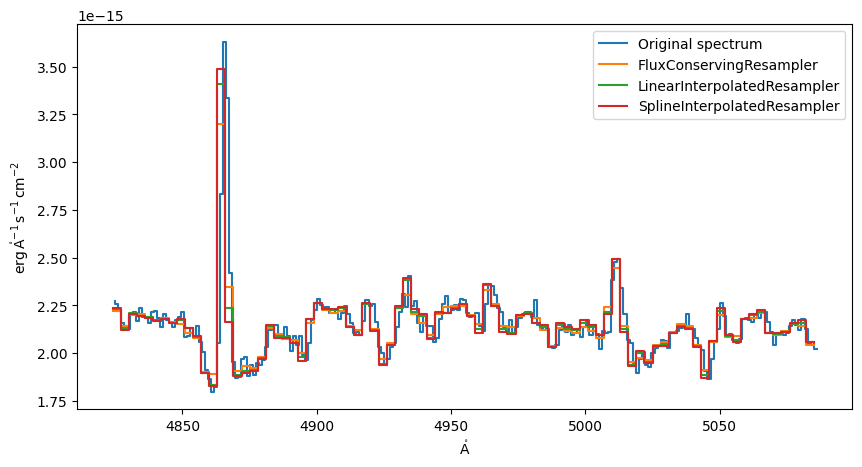

In [33]:
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler

fluxcon = FluxConservingResampler()
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid) 

linear = LinearInterpolatedResampler()
new_spec_lin = linear(input_spec, new_disp_grid)

spline = SplineInterpolatedResampler()
new_spec_sp = spline(input_spec, new_disp_grid) 

f, ax = plt.subplots(figsize=(10, 5)) 
ax.step(input_spec.spectral_axis, input_spec.flux, label='Original spectrum') 
ax.step(new_spec_fluxcon.spectral_axis, new_spec_fluxcon.flux, label='FluxConservingResampler')
ax.step(new_spec_lin.spectral_axis, new_spec_lin.flux, label='LinearInterpolatedResampler')
ax.step(new_spec_sp.spectral_axis, new_spec_sp.flux, label='SplineInterpolatedResampler')
ax.legend()

---
# 光谱拼接与组合
* https://specutils.readthedocs.io/en/stable/manipulation.html#splicing-combining-multiple-spectra

## 拼接两条光谱

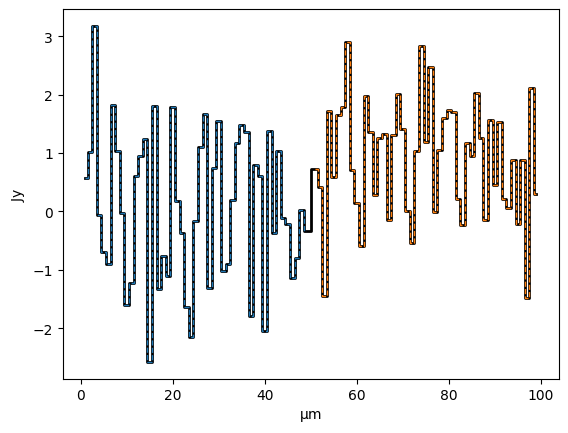

In [40]:
spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.micron, flux=np.random.randn(49)*u.Jy)
spec2 = Spectrum1D(spectral_axis=np.arange(51, 100) * u.micron, flux=(np.random.randn(49)+1)*u.Jy)

# 定义新的波长网格
new_spectral_axis = np.concatenate([spec1.spectral_axis.value, 
                                    spec2.spectral_axis.to_value(spec1.spectral_axis.unit)]) * spec1.spectral_axis.unit

# 用线性插值法对光谱进行重采样
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
new_spec1 = resampler(spec1, new_spectral_axis)
new_spec2 = resampler(spec2, new_spectral_axis)

# 将两个光谱相加
final_spec = new_spec1 + new_spec2

# 画图
f, ax = plt.subplots()  
ax.step(final_spec.spectral_axis, final_spec.flux, where='mid', c='k', lw=2) 
ax.step(spec1.spectral_axis, spec1.flux, ls='--', where='mid', lw=1) 
ax.step(spec2.spectral_axis, spec2.flux, ls='--', where='mid', lw=1)

---
# 不确定度估计
* https://specutils.readthedocs.io/en/stable/manipulation.html#uncertainty-estimation

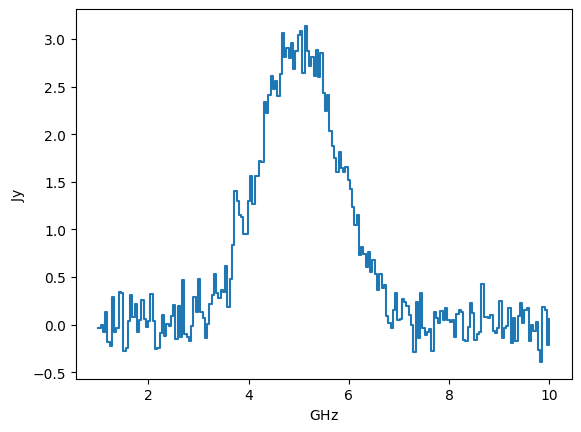

In [42]:
"""
定义一个没有不确定度, 但是有噪声的光谱
"""
from astropy.modeling import models

spectral_axis = np.linspace(10, 1, 200) * u.GHz
spectral_model = models.Gaussian1D(amplitude=3*u.Jy, mean=5*u.GHz, stddev=0.8*u.GHz)
flux = spectral_model(spectral_axis)
flux += np.random.default_rng(42).normal(0., 0.2, spectral_axis.shape) * u.Jy

noisy_gaussian = Spectrum1D(spectral_axis=spectral_axis, flux=flux)

fig, ax = plt.subplots()
ax.step(noisy_gaussian.spectral_axis, noisy_gaussian.flux)

In [46]:
from specutils import SpectralRegion
from specutils.manipulation import noise_region_uncertainty

# 使用非谱线区域的光谱测量光谱的不确定度
noise_region = SpectralRegion([(10, 7), (3, 0)] * u.GHz)
spec_w_unc = noise_region_uncertainty(noisy_gaussian, noise_region)
type(spec_w_unc)

specutils.spectra.spectrum1d.Spectrum1D

In [48]:
spec_w_unc.uncertainty.unit

Unit("Jy")

In [50]:
noise_region = SpectralRegion([(0, 25), (175, 200)]*u.pix)  # 也可以按像素定义光谱区
spec_w_unc = noise_region_uncertainty(noisy_gaussian, noise_region)
spec_w_unc.uncertainty[::20] 

StdDevUncertainty([0.17547552, 0.17547552, 0.17547552, 0.17547552,
                   0.17547552, 0.17547552, 0.17547552, 0.17547552,
                   0.17547552, 0.17547552])

---
# S/N Threshold Mask
* https://specutils.readthedocs.io/en/stable/manipulation.html#s-n-threshold-mask

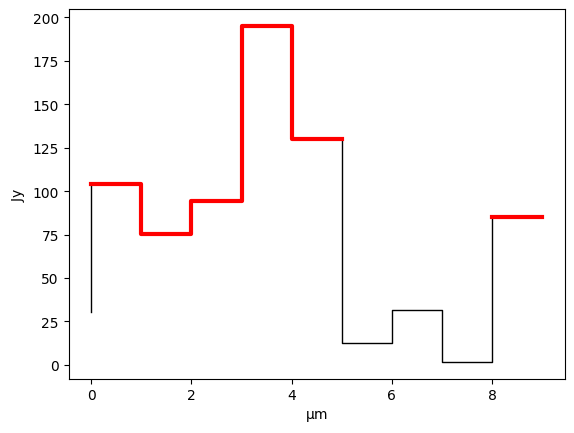

In [87]:
import numpy as np
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from specutils import Spectrum1D
from specutils.manipulation import snr_threshold

wavelengths = np.arange(0, 10)*u.um
rng = np.random.default_rng(42)
flux = 100*np.abs(rng.standard_normal(10))*u.Jy
uncertainty = StdDevUncertainty(np.abs(rng.standard_normal(10))*u.Jy)
spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux, uncertainty=uncertainty)

import copy
spectrum_masked = copy.deepcopy(snr_threshold(spectrum, 50))  # 此函数返回的光谱类与原始光谱类关联

# To create a masked flux array
flux_masked = spectrum_masked.flux
flux_masked[spectrum_masked.mask] = np.nan

fig, ax = plt.subplots()
ax.step(spectrum.spectral_axis, spectrum.flux, c='black', lw=1)
ax.step(spectrum_masked.spectral_axis, spectrum_masked.flux, c='red', lw=3)

---
# 移动光谱
* https://specutils.readthedocs.io/en/stable/manipulation.html#shifting
* 这里指的是直接给光谱轴平移, 而不是将光谱移动到指定的红移处

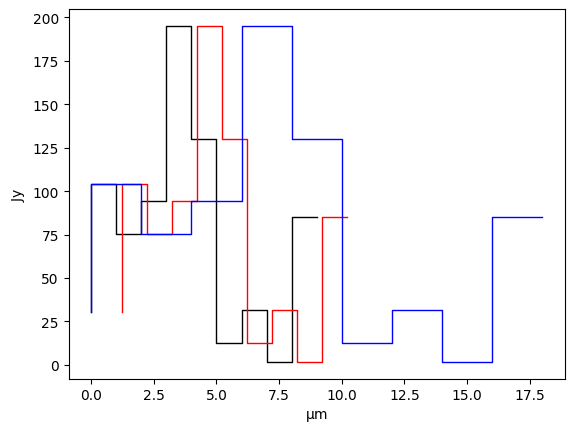

In [99]:
from specutils import Spectrum1D
wavelengths = np.arange(0, 10) * u.um
flux = 100 * np.abs(np.random.default_rng(42).standard_normal(10)) * u.Jy
spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)

# 平移光谱
shift = 12300 * u.AA
new_spec = Spectrum1D(spectral_axis=spectrum.spectral_axis + shift, flux=spectrum.flux)

# 将光谱平移到红移为1的位置
new_spec_z = copy.deepcopy(spectrum)
new_spec_z.shift_spectrum_to(redshift=1)

fig, ax = plt.subplots()
ax.step(spectrum.spectral_axis, spectrum.flux, c='black', lw=1)
ax.step(new_spec.spectral_axis, new_spec.flux, c='red', lw=1)
ax.step(new_spec_z.spectral_axis, new_spec_z.flux, c='blue', lw=1)

---
# 替换区域
* https://specutils.readthedocs.io/en/stable/manipulation.html#replacing-a-region
* 使用模型(默认为三次样条插值)替换指定的光谱区

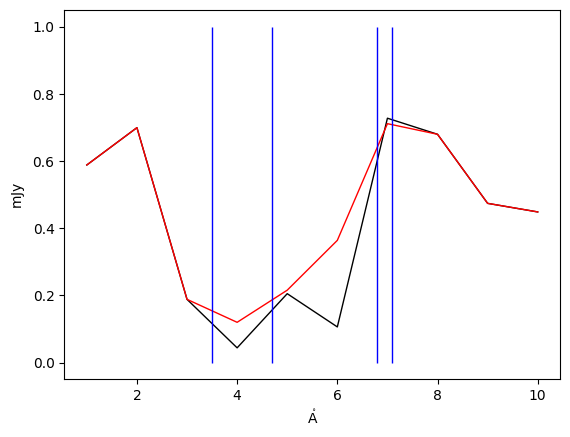

In [145]:
from specutils.manipulation.model_replace import model_replace
np.random.seed(2024)
wave_val = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
flux_val = np.random.rand(10)
input_spectrum = Spectrum1D(spectral_axis=wave_val * u.AA, flux=flux_val * u.mJy)

spline_knots = [3.5, 4.7, 6.8, 7.1] * u.AA
result = model_replace(input_spectrum, replace_region=None, model=spline_knots)

fig, ax = plt.subplots()
ax.plot(input_spectrum.spectral_axis, input_spectrum.flux, c='black', lw=1)
ax.plot(result.spectral_axis, result.flux, c='red', lw=1)
# 绘制spline_knots列表点为横坐标的竖线
ax.vlines(spline_knots, 0, 1, color='blue', lw=1)

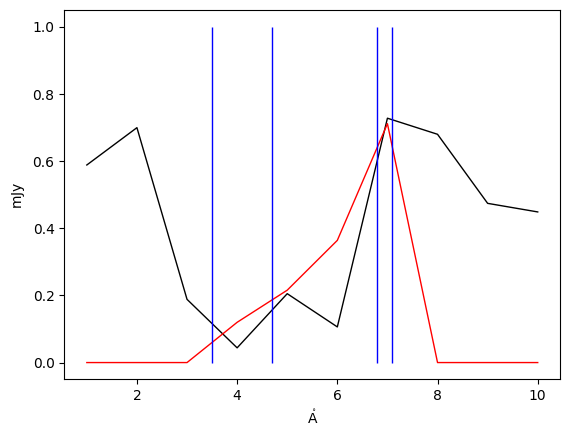

In [146]:
"""
将制定的光谱区之外的数据点替换成0
"""
spline_knots = [3.5, 4.7, 6.8, 7.1] * u.AA
result = model_replace(input_spectrum, None, model=spline_knots, extrapolation_treatment='zero_fill')

fig, ax = plt.subplots()
ax.plot(input_spectrum.spectral_axis, input_spectrum.flux, c='black', lw=1)
ax.plot(result.spectral_axis, result.flux, c='red', lw=1)
# 绘制spline_knots列表点为横坐标的竖线
ax.vlines(spline_knots, 0, 1, color='blue', lw=1)

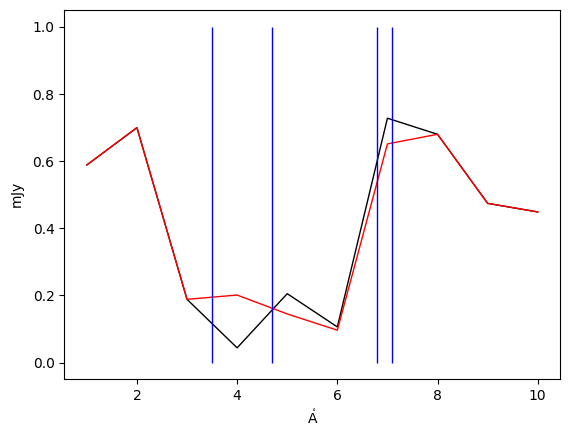

In [147]:
"""
使用光谱区
"""

from specutils import SpectralRegion

region = SpectralRegion(3.5*u.AA, 7.1*u.AA)
result = model_replace(input_spectrum, region, model=4)

fig, ax = plt.subplots()
ax.plot(input_spectrum.spectral_axis, input_spectrum.flux, c='black', lw=1)
ax.plot(result.spectral_axis, result.flux, c='red', lw=1)
# 绘制spline_knots列表点为横坐标的竖线
ax.vlines(spline_knots, 0, 1, color='blue', lw=1)

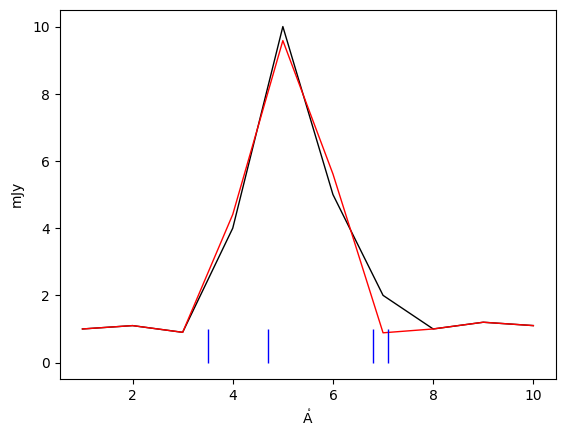

In [148]:
"""
使用高斯模型
"""
from astropy.modeling import models
from specutils.fitting import fit_lines

flux_val = np.array([1, 1.1, 0.9, 4., 10., 5., 2., 1., 1.2, 1.1])
input_spectrum = Spectrum1D(spectral_axis=wave_val * u.AA, flux=flux_val * u.mJy)

model = models.Gaussian1D(10, 5.6, 1.2)
fitted_model = fit_lines(input_spectrum, model)

region = SpectralRegion(3.5*u.AA, 7.1*u.AA)
result = model_replace(input_spectrum, region, model=fitted_model)


fig, ax = plt.subplots()
ax.plot(input_spectrum.spectral_axis, input_spectrum.flux, c='black', lw=1)
ax.plot(result.spectral_axis, result.flux, c='red', lw=1)
# 绘制spline_knots列表点为横坐标的竖线
ax.vlines(spline_knots, 0, 1, color='blue', lw=1)